In [1]:
import os
import re
import nltk
import mpld3
import joblib
import string
import codecs
# import sklearn.externals
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from itertools import chain
from functools import partial

from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer

from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import dendrogram

from gensim import corpora
from gensim import models
from gensim import similarities 

In [2]:
%matplotlib inline

In [3]:
%%html
<style>
table {float:left}
</style>

# Data

## load

In [4]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
links = open('link_list_imdb.txt').read().split('\n')
synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
genres = open('genres_list.txt').read().split('\n')
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')

## etl

In [5]:
synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki

In [6]:
synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [7]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [8]:
ranks = range(len(titles))

In [9]:
print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

101 titles
101 links
101 synopses
101 genres


## table

films, 电影

| 字段名| 字段说明 |
| :-- | :-- |
| title | 名称 |
| rank | 排名 |
| synopses | 概要 |
| genres | 流派 |

In [10]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'genre': genres}
df_films = pd.DataFrame(films)

In [11]:
df_films.shape

(101, 4)

In [12]:
df_films.head(1)

,title,rank,synopsis,genre
0,The Godfather,0,Plot [edit] [ [ edit edit ] ] \n On ...,"[u' Crime', u' Drama']"


# Preprocess

## tokenizing

In [13]:
def tokenize(stemmer, text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stemmed = [stemmer.stem(t) for t in filtered_tokens]
    return filtered_tokens, stemmed

In [14]:
nltk.download('punkt')
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package punkt to /home/wangyh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
totalvocab_tokenized, totalvocab_stemmed = zip(*map(partial(tokenize, stemmer), synopses))
totalvocab_tokenized = chain.from_iterable(totalvocab_tokenized)
totalvocab_stemmed = chain.from_iterable(totalvocab_stemmed)

In [16]:
df_tokens = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [17]:
df_tokens.head(1)

,words
plot,Plot


# Embedding

## n-dim

In [18]:
def tokenizer(stemmer, text):
    _, stemmed = tokenize(stemmer, text)
    return stemmed

In [19]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.8, 
    max_features=200000,
    min_df=0.2, 
    stop_words='english',
    use_idf=True, 
    tokenizer=partial(tokenizer, stemmer), 
    ngram_range=(1,3)
)

In [20]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

/home/wangyh/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


CPU times: user 6.92 s, sys: 64 ms, total: 6.98 s
Wall time: 6.98 s


In [21]:
print(tfidf_matrix.shape)

(101, 532)


## n-dim distance

In [22]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [23]:
dist.shape

(101, 101)

## 2-dim

In [24]:
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

In [25]:
# shape = (n_samples, n_components)
pos = mds.fit_transform(dist)
pos.shape

(101, 2)

In [26]:
xs, ys = pos[:, 0], pos[:, 1]

# Clustering

## k-means

In [27]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters)

In [28]:
# TODO: may be need normalize/scaling before clustering

In [29]:
%time km.fit(tfidf_matrix)

CPU times: user 340 ms, sys: 4 ms, total: 344 ms
Wall time: 85.8 ms


KMeans(n_clusters=5)

In [30]:
# joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

## linkage ward

## latent dirichlet allocation

In [31]:
# TODO:

#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [32]:
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/wangyh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]
len(preprocess)

101

In [34]:
%time tokenized_text = [tokenize(stemmer, text)[1] for text in preprocess]

CPU times: user 3.33 s, sys: 4 ms, total: 3.33 s
Wall time: 3.33 s


In [35]:
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
print(len(texts[0]))

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 425 ms
1839


In [36]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [37]:
corpus = [dictionary.doc2bow(text) for text in texts]
len(corpus)

101

In [38]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
print(lda[corpus[0]])

CPU times: user 2min 50s, sys: 3.94 s, total: 2min 54s
Wall time: 43.6 s
[(0, 0.038551584), (3, 0.5345929), (4, 0.42660794)]


In [39]:
topics = lda.print_topics(5, num_words=20)

topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix[:1]

[(0,
  [('kill', 0.0069631403),
   ('order', 0.0051749544),
   ('offic', 0.004559298),
   ('command', 0.003969843),
   ('two', 0.0038035745),
   ('soldier', 0.0037195657),
   ('attack', 0.0034100628),
   ('men', 0.0033914663),
   ('attempt', 0.0033565476),
   ('first', 0.0031617805),
   ('arriv', 0.003074147),
   ('death', 0.0030452802),
   ('forc', 0.0030248535),
   ('son', 0.0028009492),
   ('boat', 0.002800699),
   ('end', 0.002790683),
   ('plan', 0.0027200193),
   ('escap', 0.0027186812),
   ('set', 0.0026863823),
   ('fire', 0.0026277583)])]

# Report

In [40]:
def pprint(num_clusters, order_centroids, terms, df_tokens, df_films):
    print("Top terms per cluster:")
    print()

    for i in range(num_clusters):

        """ term import -> term vector
        """

        print("Cluster %d words:" % i, end='')

        for ind in order_centroids[i, :6]:
            term = terms[ind]
            term = term.split(' ')
            token = df_tokens.loc[term].values.tolist()[0][0]
            token = token.encode('utf-8', errors='ignore')
            print(token, end=',')

        print()
        print()

        """ cluster id -> title
        """

        print("Cluster %d titles:" % i, end='')

        for title in df_films[df_films['cluster']==i]['title'].values.tolist():
            print(' %s,' % title, end='')

        print()
        print()

In [41]:
def report_pprint(df_films, clusters, terms, cluster_centers_, num_clusters, df_tokens):
    """
    Parameter
    --------
    df_films : pd.DataFrame, shape=(n_samples, n_dim)
        title, rank, synopsis, genre
        
    clusters : list
    
    terms : vector feature name
    
    cluster_centers_ : np.array, shape=(n_clusters, n_terms)
    
    num_clusters : int
    
    df_tokens : pd.DataFrame, shape=(n_tokens), index=stemmed
        tokens repeat
    """
    
    # add cluster info
    df_films['cluster'] = clusters
    df_films['cluster'].value_counts()
    df_films[['rank', 'cluster']].groupby('cluster').mean()
    
    # top tokens
    # terms = tfidf_vectorizer.get_feature_names()
    print(len(terms))
    print(cluster_centers_.shape)
    order_centroids = cluster_centers_.argsort()[:, ::-1]
    
    pprint(num_clusters, order_centroids, terms, df_tokens, df_films)

In [42]:
def visualizing(groups, cluster_names, cluster_colors, df_cluster):
    
    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05) # adds 5% padding to the autoscaling


    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')

        ax.set_aspect('auto')

        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',   # both major and minor ticks are affected
            bottom='off',    # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')

        ax.tick_params(\
            axis= 'y',
            which='both',
            left='off',
            top='off',
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point


    #add label in x,y position with the label as the film title
    for i in range(len(df_cluster)):
        ax.text(df_cluster.iloc[i]['x'], df_cluster.iloc[i]['y'], df_cluster.iloc[i]['title'], size=8)  


    plt.show()
    #plt.savefig('clusters_small_noaxes.png', dpi=200)

In [43]:
def report_visualizing(xs, ys, clusters, titles, cluster_colors, cluster_names):

    df_cluster = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles))
    print(df_cluster.shape)
    print(df_cluster.head(1))

    # cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    # cluster_names = {
    #     0: 'Family, home, war', 
    #     1: 'Police, killed, murders', 
    #     2: 'Father, New York, brothers', 
    #     3: 'Dance, singing, love', 
    #     4: 'Killed, soldiers, captain'}

    groups = df_cluster.groupby('label')
    
    visualizing(groups, cluster_names, cluster_colors, df_cluster)

In [44]:
def report(df_films, clusters, terms, cluster_centers_, num_clusters, df_tokens, xs, ys, titles, cluster_colors, cluster_names):
    report_pprint(df_films, clusters, terms, cluster_centers_, num_clusters, df_tokens)
    report_visualizing(xs, ys, clusters, titles, cluster_colors, cluster_names)

In [45]:
# cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
cluster_colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red', 4: 'purple'}

cluster_names = {
    0: 'Family, home, war', 
    1: 'Police, killed, murders', 
    2: 'Father, New York, brothers', 
    3: 'Dance, singing, love', 
    4: 'Killed, soldiers, captain'}

## k-means

In [46]:
clusters = km.labels_.tolist()
cluster_centers_ = km.cluster_centers_
terms = tfidf_vectorizer.get_feature_names()

532
(5, 532)
Top terms per cluster:

Cluster 0 words:b'George',b'marries',b'family',b'John',b'James',b'playing',

Cluster 0 titles: It's a Wonderful Life, The Philadelphia Story, The King's Speech, A Place in the Sun, Tootsie,

Cluster 1 words:b'soldiers',b'killed',b'Army',b'command',b'general',b'orders',

Cluster 1 titles: Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Raiders of the Lost Ark, Patton, Jaws, The Good, the Bad and the Ugly, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Deer Hunter, All Quiet on the Western Front, Stagecoach, Mutiny on the Bounty,

Cluster 2 words:b'Police',b'car',b'killed',b'says',b'asks',b'friends',

Cluster 2 titles: The Shawshank Redemption, Casablanca, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Psycho, Sunset Blvd., Vertig

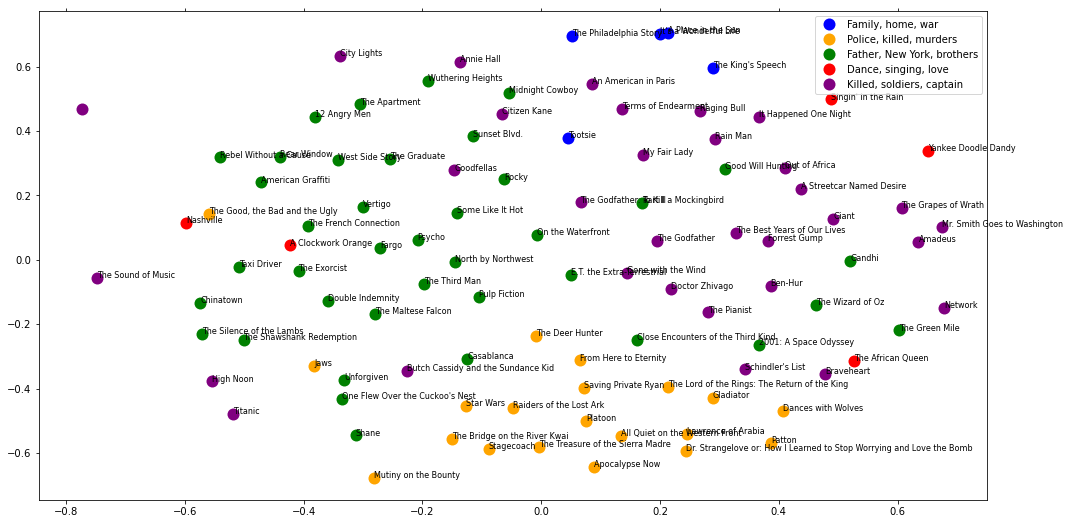

In [47]:
report(df_films, clusters, terms, cluster_centers_, num_clusters, df_tokens, xs, ys, titles, cluster_colors, cluster_names)

## latent dirichlet allocation

In [48]:
clusters = list(map(lambda x: sorted(x, key=lambda e: e[1], reverse=True)[0][0], lda[corpus]))

In [49]:
terms = list(set([e[0] for c in topics_matrix for e in c[1]]))
values = [{e[0]:e[1] for e in c[1]} for c in topics_matrix]
cluster_centers_ = np.array([[values[i].get(k,0.) for k in terms] for i in range(len(values))])

71
(5, 71)
Top terms per cluster:

Cluster 0 words:b'killed',b'orders',b'office',b'command',b'two',b'soldiers',

Cluster 0 titles: One Flew Over the Cuckoo's Nest, Citizen Kane, Lawrence of Arabia, Forrest Gump, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Amadeus, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, Raiders of the Lost Ark, Patton, Butch Cassidy and the Sundance Kid, Dances with Wolves, The Deer Hunter, Rain Man, Network, The African Queen, Mutiny on the Bounty, ,

Cluster 1 words:b'soldiers',b'killed',b'Sharks',b'men',b'orders',b'wounded',

Cluster 1 titles: Saving Private Ryan, Ben-Hur, Jaws, The Treasure of the Sierra Madre, Platoon, The Pianist, Stagecoach,

Cluster 2 words:b'ship',b'go',b'votes',b'two',b'State',b'running',

Cluster 2 titles: Titanic, Vertigo, Star Wars, Some Like It Hot, 12 Angry Men, To Kill a Mockingbird, City Lights, A Place in the Sun, Mr. Smith Goes to Washington, Th

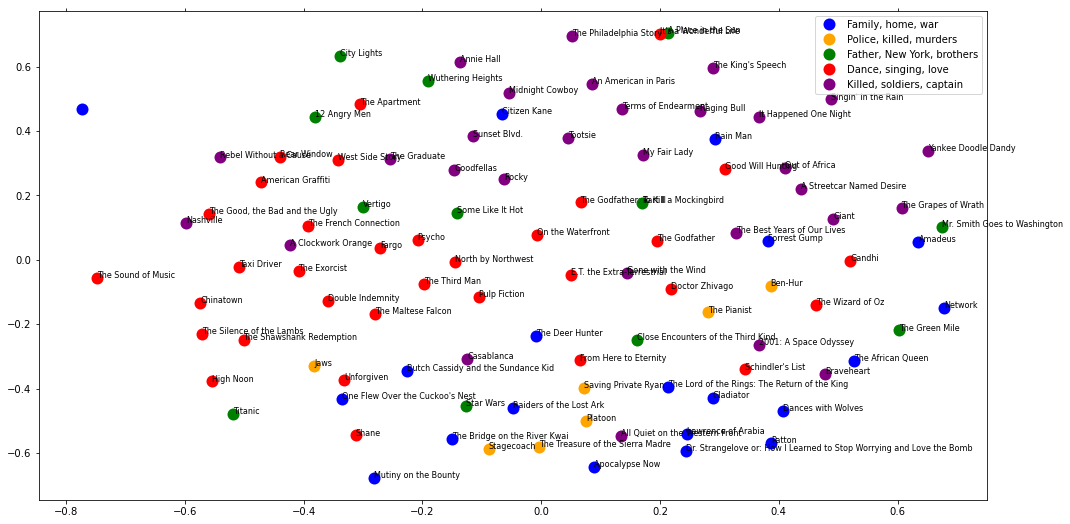

In [50]:
report(df_films, clusters, terms, cluster_centers_, num_clusters, df_tokens, xs, ys, titles, cluster_colors, cluster_names)

## visualizing hierarchical